# Predictions across models analysis
Assumes that both the covEcho and the segmentation analysis notebooks have been run to produce the predictions of the covEcho and the segmentation model.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
covEcho = pd.read_csv("./02_covEcho/predictions_covEcho_class_count_video_lvl_COVID.csv", index_col=0)

# Append "covEcho" to all columns except y to identify
covEcho.columns = ["covEcho_" + col if col != "y" else col for col in covEcho.columns]
covEcho

In [ ]:
segmentation = pd.read_csv("./03_Roy_segmentation/predictions_segmentation_class_area_video_lvl_COVID.csv", index_col=0)

# Append "segmentation" to all columns except y to identify
segmentation.columns = ["segmentation_" + col if col != "y" else col for col in segmentation.columns]
segmentation

In [ ]:
# Merge the two data frames
merged = pd.merge(covEcho, segmentation, on=["video_name", "y"], how="inner")
error_cols = [col for col in merged.columns if "error" in col]
# Keep only columns containing "error" or "y"
merged_error = merged[["y"] + error_cols]
#merged_error = merged_error.apply(lambda x: abs(x))
# Sum up all error values for each row
merged_error["sum"] = merged_error[error_cols].sum(axis=1)
merged_error["sum_abs"] = abs(merged_error[error_cols]).sum(axis=1)

# Sort by sum
merged_error = merged_error.sort_values(by="sum", ascending=True)
merged_error.head()

## Add patient

In [7]:
import sys; sys.path.insert(0, "./utils/")
from data_utils import get_data_location, get_clinical_df, get_bluepoints_df, get_manual_severity_scores
from ml_pipeline import highlight_max
from statistics import evaluate_logits

DATA_PATH = get_data_location()
print("Infered Data path:", DATA_PATH)

Infered Data path: /itet-stor/mrichte/covlus_bmicnas02/


In [ ]:
# Clinical data
clinical_data = get_clinical_df()

clinical_data = clinical_data[["Video ID", "clin_diagn#COVID19_pneumonia", "adm_date"]]
clinical_data.columns = ["Patient ID", "COVID19", "adm_date"]
# Transform to datetime. Format is dd-mm-yyyy
clinical_data["adm_date"] = pd.to_datetime(clinical_data["adm_date"], format="%d-%m-%Y")

# Bluepoint data
bp = get_bluepoints_df()

df = pd.merge(bp, clinical_data, on="Patient ID").sort_values(by=["Patient ID", "Bluepoint"])
# Reorder columns
df = df[["Patient ID", "Bluepoint", "video_name", "COVID19", "adm_date"]]

# Manual severity scores
severity_manual = get_manual_severity_scores()
severity_manual = severity_manual[["Severity Score", "video_name", "Tablet"]]
df = pd.merge(df, severity_manual, on=["video_name"])

# Merge with the predictions
df = pd.merge(df, merged_error, on="video_name")

df.sort_values(by=["sum", "Patient ID"], ascending=True, inplace=True)
df.head()

In [ ]:
# Plot sum of errors 
sns.set()
# sns.set_style("whitegrid")
# sns.set_context("paper", font_scale=1.5)
plt.figure(figsize=(20, 5))
sns.barplot(x="video_name", y="sum", data=df, hue="Tablet")
plt.xticks(rotation=90)
plt.xlabel("Video name")
# Decrease x label size
plt.xticks(fontsize=4)
plt.ylabel("Sum of errors")
plt.title("Sum of errors for each video")
plt.legend(loc="lower right")
plt.tight_layout()
# plt.savefig("sum_of_errors.png", dpi=300)
plt.show()

In [10]:
# Statitical analysis Tablet A vs Tablet C
from scipy.stats import ttest_ind

Tabelt_A = df[df["Tablet"] == "A"]
Tabelt_C = df[df["Tablet"] == "C"]

stat, p = ttest_ind(Tabelt_A["sum"], Tabelt_C["sum"])
print("Mean sum of errors for Tablet A:", Tabelt_A["sum"].mean())
print("Mean sum of errors for Tablet C:", Tabelt_C["sum"].mean())

print(f"stat={stat}, p={p}")

Mean sum of errors for Tablet A: 0.5394190871369294
Mean sum of errors for Tablet C: -0.7831325301204819
stat=3.4893028387704157, p=0.0005517165810145092


In [11]:
# Statitical analysis Tablet A vs Tablet C
from scipy.stats import ttest_ind

Tabelt_A = df[df["Tablet"] == "A"]
Tabelt_C = df[df["Tablet"] == "C"]

stat, p = ttest_ind(Tabelt_A["sum"], Tabelt_C["sum"])
print("Mean sum of errors for Tablet A:", Tabelt_A["sum_abs"].mean())
print("Mean sum of errors for Tablet C:", Tabelt_C["sum_abs"].mean())

print(f"stat={stat}, p={p}")

Mean sum of errors for Tablet A: 1.9751037344398341
Mean sum of errors for Tablet C: 2.710843373493976
stat=3.4893028387704157, p=0.0005517165810145092


We find a statistically significant differenve between the prediction error on Data from Tablet A and Data from Tablet C. On average Tablet A seems to be more prone to False Positives (Error > 0) and Tablet C more prone to False Negatives (Error < 0). Why the fuck is that?

Check if one Tablet was used at a different time in the study.

Correlation between sum of errors and date of admission: corr=-0.15628829599625052, p=0.004807399725394916


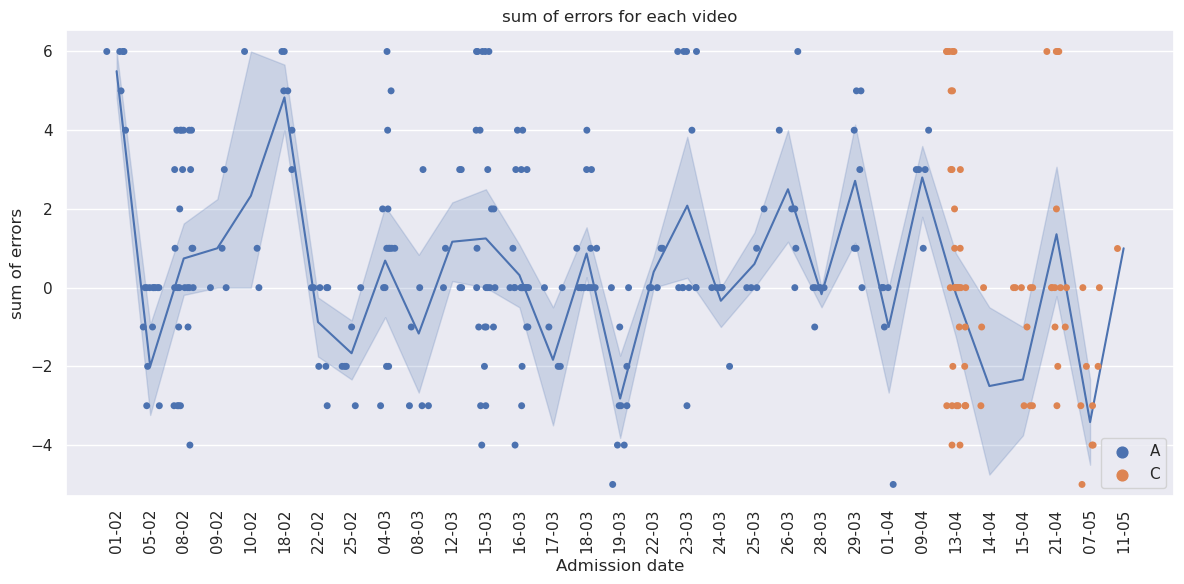

In [12]:
# Correlate sum of errors with date of admission
from scipy.stats import pearsonr
import numpy as np
import matplotlib.dates as mdates

# Transform to ordinal
df["adm_date_ordinal"] = df["adm_date"].apply(lambda x: x.toordinal())
df["adm_date_str"] = df["adm_date"].apply(lambda x: x.strftime("%d-%m"))
# Correlate
corr, p = pearsonr(df["adm_date_ordinal"], df["sum"])
print(f"Correlation between sum of errors and date of admission: corr={corr}, p={p}")

# Plot adm_date vs sum of errors with tablet as hue
sns.set()

fig, ax = plt.subplots(figsize=(12, 6))
sns.stripplot(x="adm_date_str", y="sum", data=df.sort_values("adm_date"), hue="Tablet", jitter=0.3)
# Add a line for the mean
sns.lineplot(x="adm_date_str", y="sum", data=df.sort_values("adm_date"), estimator=np.mean)
plt.xticks(rotation=90)
# Change x label format to only display the day and moth of the admission date
plt.xlabel("Admission date")
plt.ylabel("sum of errors")
plt.title("sum of errors for each video")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

Correlation between sum_abs of errors and date of admission: corr=0.03835779328783854, p=0.4914370056675753


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


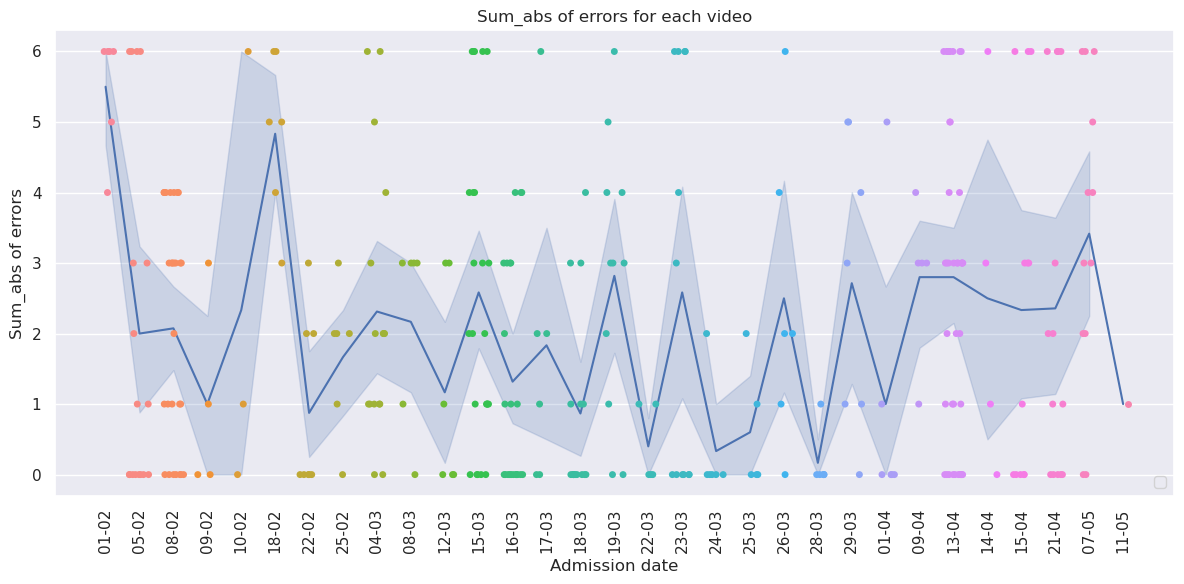

In [13]:
# Correlate
corr, p = pearsonr(df["adm_date_ordinal"], df["sum_abs"])
print(f"Correlation between sum_abs of errors and date of admission: corr={corr}, p={p}")

# Plot adm_date vs sum_abs of errors with tablet as hue
sns.set()


fig, ax = plt.subplots(figsize=(12, 6))
sns.stripplot(x="adm_date_str", y="sum_abs", data=df.sort_values("adm_date"), jitter=0.3)
sns.lineplot(x="adm_date_str", y="sum_abs", data=df.sort_values("adm_date"), estimator=np.mean)
plt.xticks(rotation=90)
# Change x label format to only display the day and moth of the admission date
plt.xlabel("Admission date")
plt.ylabel("Sum_abs of errors")
plt.title("Sum_abs of errors for each video")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [14]:
# Binning by months
df["adm_date_month"] = df["adm_date"].apply(lambda x: x.strftime("%m-%Y"))
df["adm_date_month"] = pd.to_datetime(df["adm_date_month"], format="%m-%Y")
# Adm date month as string containint month name
df["adm_date_month_str"] = df["adm_date_month"].apply(lambda x: x.strftime("%b %Y"))
# df["adm_date_month_str"] = df["adm_date_month"].apply(lambda x: x.strftime("%m-%Y"))

# Binning by weeks
df["adm_date_week"] = df["adm_date"].apply(lambda x: x.strftime("%W-%Y"))
df["adm_date_week"] = df["adm_date_week"].apply(lambda x: int(x[:2]))

df["adm_date_two_weeks"] = pd.cut(df["adm_date_week"], bins=8)
df["adm_date_two_weeks"] = df["adm_date_two_weeks"].apply(lambda x: str(int(x.left)) + "-" + str(int(x.right)))

Correlation between sum of errors and date of admission (month): corr=-0.18802924687909756, p=0.000669344164311125
Correlation between sum of errors and date of admission (week): corr=-0.14393688014914505, p=0.009476348203307849


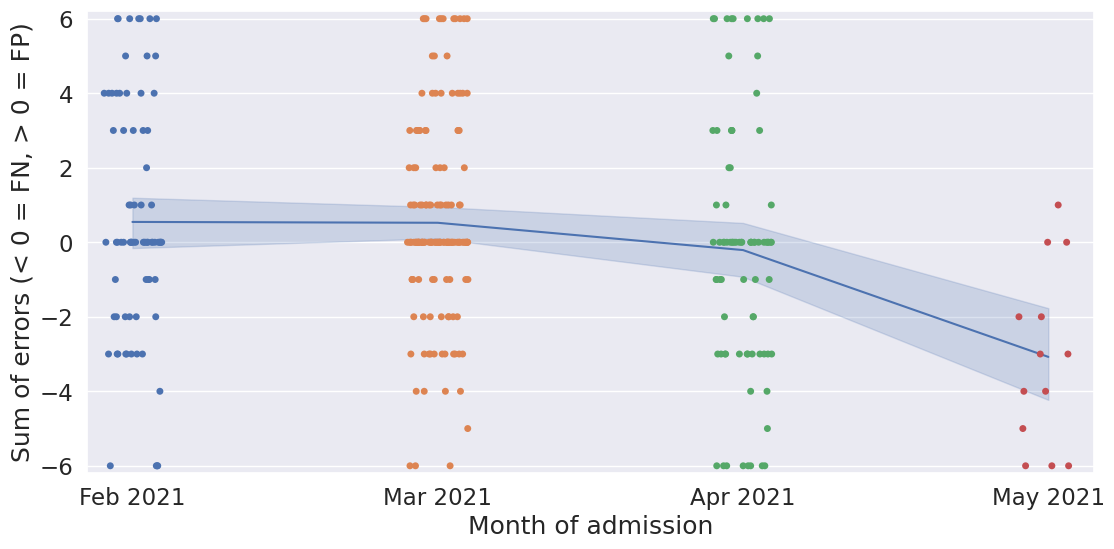

In [15]:
# Correlate by months
corr, p = pearsonr(df["adm_date_month"].apply(lambda x: x.toordinal()), df["sum"])
print(f"Correlation between sum of errors and date of admission (month): corr={corr}, p={p}")

# Correlate by weeks
corr, p = pearsonr(df["adm_date_week"], df["sum"])
print(f"Correlation between sum of errors and date of admission (week): corr={corr}, p={p}")

sns.set(font_scale=1.5)
# Plot adm_date binned monthly vs sum of errors 
fig, ax = plt.subplots(figsize=(13, 6))
sns.stripplot(x="adm_date_month_str", y="sum", data=df.sort_values("adm_date_month"))
sns.lineplot(x="adm_date_month_str", y="sum", data=df.sort_values("adm_date_month"), estimator=np.mean)
# Set y axis range -6 to 6
plt.ylim(-6.2, 6.2)
# plt.xticks(rotation=90)
# Label axes
plt.xlabel("Month of admission")
plt.ylabel("Sum of errors (< 0 = FN, > 0 = FP)")
plt.show()

Correlation between sum of errors and date of admission (month): corr=0.08154032331623343, p=0.14305932858229


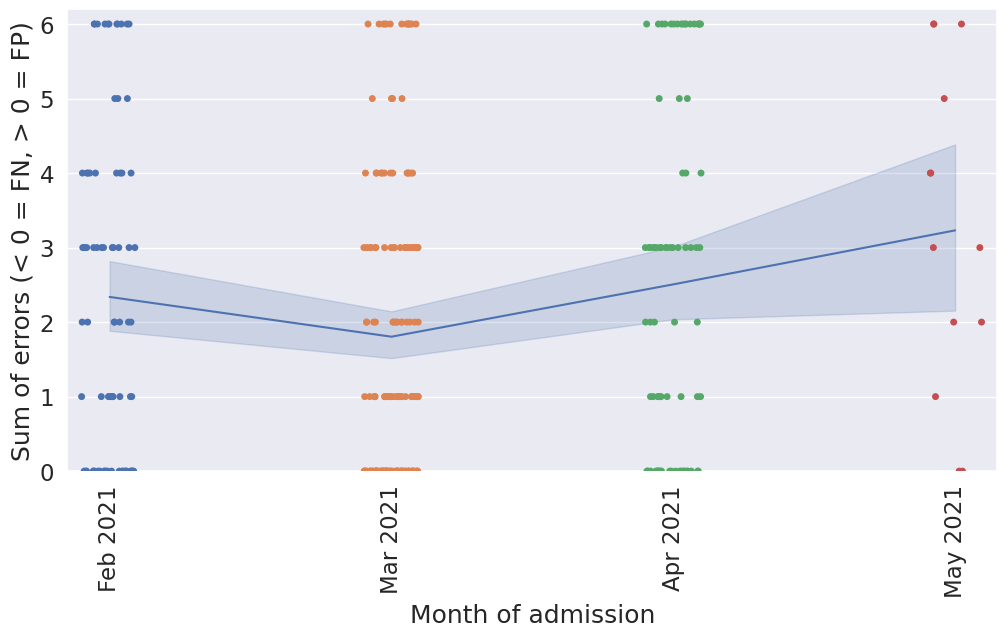

In [16]:

# Correlate by months
corr, p = pearsonr(df["adm_date_month"].apply(lambda x: x.toordinal()), df["sum_abs"])
print(f"Correlation between sum of errors and date of admission (month): corr={corr}, p={p}")

# Plot adm_date binned monthly vs sum of errors 
fig, ax = plt.subplots(figsize=(12, 6))
sns.stripplot(x="adm_date_month_str", y="sum_abs", data=df.sort_values("adm_date_month"))
sns.lineplot(x="adm_date_month_str", y="sum_abs", data=df.sort_values("adm_date_month"), estimator=np.mean)
# Set y axis range -6 to 6
plt.ylim(0, 6.2)
plt.xticks(rotation=90)
# Label axes
plt.xlabel("Month of admission")
plt.ylabel("Sum of errors (< 0 = FN, > 0 = FP)")
plt.show()

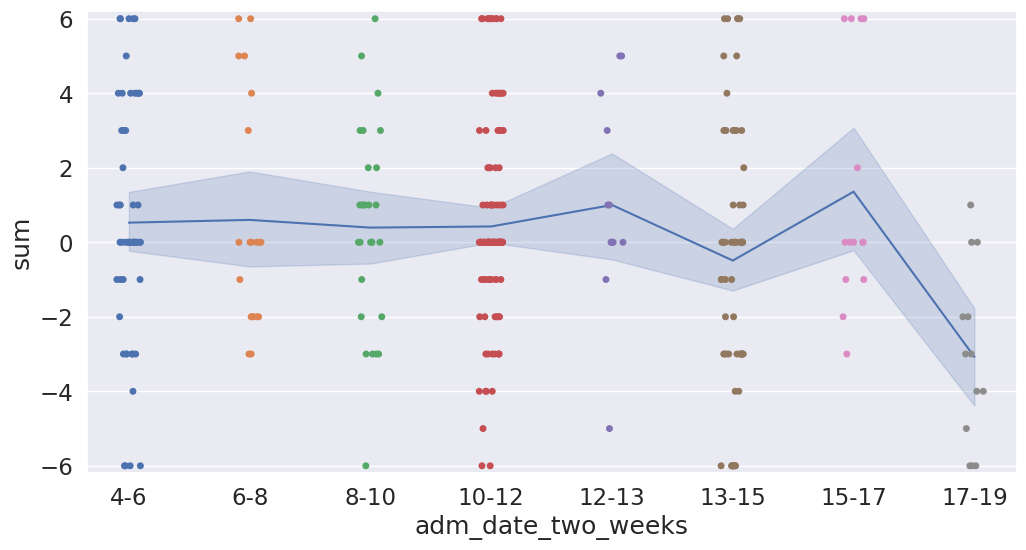

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.stripplot(x="adm_date_two_weeks", y="sum", data=df.sort_values("adm_date"))
sns.lineplot(x="adm_date_two_weeks", y="sum", data=df.sort_values("adm_date"), estimator=np.mean)
plt.ylim(-6.2, 6.2)
plt.show()

In [18]:
# Correlate sum of errors with manual severity score
from scipy.stats import pearsonr

stat, p = pearsonr(df["sum"], df["Severity Score"])
print(f"Severity score correlated with sum of errors: stat={stat:.3f}, p={p:.3f}")

stat, p = pearsonr(df["sum_abs"], df["Severity Score"])
print(f"Severity score correlated with sum_abs of errors: stat={stat:.3f}, p={p:.3f}")

Severity score correlated with sum of errors: stat=0.200, p=0.000
Severity score correlated with sum_abs of errors: stat=-0.015, p=0.786


In [19]:
# Split time into February and March vs April and May and perform t-test
df["adm_date_first_half"] = df["adm_date_month"] < pd.to_datetime("2021-04-01")

# T-test first half vs second half errors
from scipy.stats import ttest_ind
feb_march = df[df["adm_date_first_half"] == True]["sum"]
apr_may = df[df["adm_date_first_half"] == False]["sum"]
stat, p = ttest_ind(feb_march, apr_may)
print(f"February and March vs April and May: stat={stat:.3f}, p={p:.3f}")
# Print means
print(f"February and March mean: {feb_march.mean():.3f}")
print(f"April and May mean: {apr_may.mean():.3f}")

# T-test first half vs second half for absolute errors
feb_march = df[df["adm_date_first_half"] == True]["sum_abs"]
apr_may = df[df["adm_date_first_half"] == False]["sum_abs"]
stat, p = ttest_ind(feb_march, apr_may)
print(f"February and March vs April and May (absolute error): stat={stat:.3f}, p={p:.3f}")
# Print means
print(f"February and March mean: {feb_march.mean():.3f}")
print(f"April and May mean: {apr_may.mean():.3f}")

February and March vs April and May: stat=3.106, p=0.002
February and March mean: 0.530
April and May mean: -0.606
February and March vs April and May (absolute error): stat=-2.414, p=0.016
February and March mean: 1.983
April and May mean: 2.606


Interpretation: Not the absolut error is correlated with the severity score. (higher sev score = higher/lower accuracy). But the directional error (FP vs FN) is correlated with the severity score. (higher sev score = more FP, lower sev score = more FN). The model seems to learn the severity score it just is not strongly related to the covid variable.

Error is negatively correlated -> Severity score is more decoupled from the covid diagnosis towards later staged of the pandemic?
More FN -> generally lower severity score in the summer/different patient population/ different variant/ more vaccinations? But still people have COVID.

### Compare error type to severity distribution

Mean severity score for FN: 0.57 vs FP: 1.51


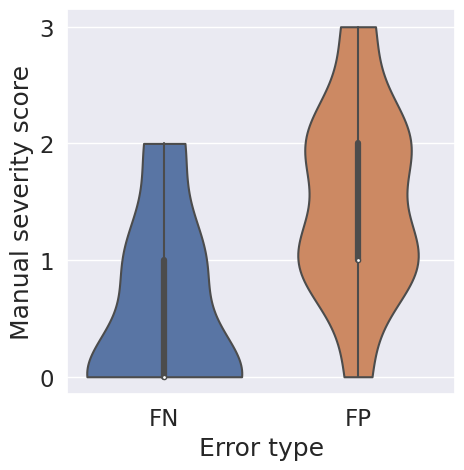

In [20]:
from statannot import add_stat_annotation

df["error_type"] = df["sum"].apply(lambda x: "FP" if x > 0 else "FN")
# All wrong are the ones that have -6 or 6 as error
all_wrong = df[(df["sum"] <= -5) | (df["sum"] >= 5)]
# Severity score as integer
# all_wrong["Severity Score"] = all_wrong["Severity Score"].astype(int)

# Print mean severity score for FP and FN
mean_FN = all_wrong[all_wrong["error_type"] == "FN"]["Severity Score"].mean()
mean_FP = all_wrong[all_wrong["error_type"] == "FP"]["Severity Score"].mean()
print(f"Mean severity score for FN: {mean_FN:.2f} vs FP: {mean_FP:.2f}")

# Plot all wrong as boxplot FN/FP against severity score
sns.set(font_scale=1.5)
plt.figure(figsize=(5, 5))
ax = sns.violinplot(y="Severity Score", x="error_type", data=all_wrong, cut=0)
# add_stat_annotation(ax, data=all_wrong, x="error_type", y="Severity Score", box_pairs=[("FP", "FN")], test="Mann-Whitney", text_format="simple", loc="outside", verbose=2)
# Y ticks as int
plt.yticks(np.arange(0, 4, 1))

plt.xlabel("Error type")
plt.ylabel("Manual severity score")
plt.show()

Welche werden von den Sev scores FN oder FP predicted?  
Hypothese: Die immer falsch klassifiziert werden haben eine hohe severity (man lang score) aber halt kein COVID. FP haben hohen sev score. FN haben niedrigen sev score.  
--> Classification Models sind am ende eigentlich severity Models.

In [ ]:
patient_df = df.groupby("Patient ID").agg({"sum": "sum", "sum_abs":"sum","COVID19": "first"})
patient_df.sort_values(by="sum_abs", ascending=False, inplace=True)
patient_df.head(10)